# Unsupervised Learning: Principal Component Analysis (PCA)

In this section, we introduce PCA, why it is useful, and the core ideas that make it work. We'll also prepare a real dataset that benefits from dimensionality reduction.

## The Why's and What's of PCA

PCA is a foundational technique for unsupervised learning and exploratory data analysis. It projects high-dimensional data to a lower-dimensional space while preserving as much variance (information) as possible.

- Why use PCA?
  - Reduce dimensionality to simplify models and speed up training
  - Remove redundancy caused by correlated features
  - Denoise data by focusing on the strongest variance directions
  - Visualize complex datasets in 2D/3D

- What does PCA do?
  - Finds new orthogonal axes (principal components) ordered by explained variance
  - First PC captures the maximum variance, second PC the next highest orthogonal variance, and so on
  - Produces: components (directions), explained variance, transformed data (scores)

## Building Blocks of PCA

1) Standardization
- Features with different scales can dominate variance. Standardize to zero mean and unit variance.

2) Covariance Matrix
- Captures how features vary together. A high covariance between two features indicates redundancy.

3) Eigen-Decomposition
- Principal components are the eigenvectors of the covariance matrix; eigenvalues represent explained variance along each component.

4) Orthogonality and Ordering
- Components are orthogonal (uncorrelated) and ordered by descending variance (eigenvalues).

5) Explained Variance Ratio
- Tells how much information each component retains. Use cumulative variance to choose number of components.

## Singular Value Decomposition (SVD): Conceptual View

SVD factors a data matrix X (after centering/standardization) as:

X = U Σ Vᵀ

- V (right singular vectors): directions of principal components
- Σ (singular values): relate to the amount of variance captured (Σ² / (n-1) ≈ eigenvalues)
- U Σ: projected data (scores) in the PC space

Why SVD for PCA?
- Numerically stable and efficient for large, possibly non-square matrices
- scikit-learn’s PCA uses an SVD-based solver under the hood

Intuition:
- SVD finds the best low-rank approximation of X by keeping the largest singular values/vectors, i.e., the directions that capture most of the structure in the data

Dataset: Wine
Shape: X=(178, 13), y=(178,)
Classes: [np.str_('class_0'), np.str_('class_1'), np.str_('class_2')]

Feature means after scaling (approx 0): [ 0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0. -0.]
Feature stds after scaling (approx 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


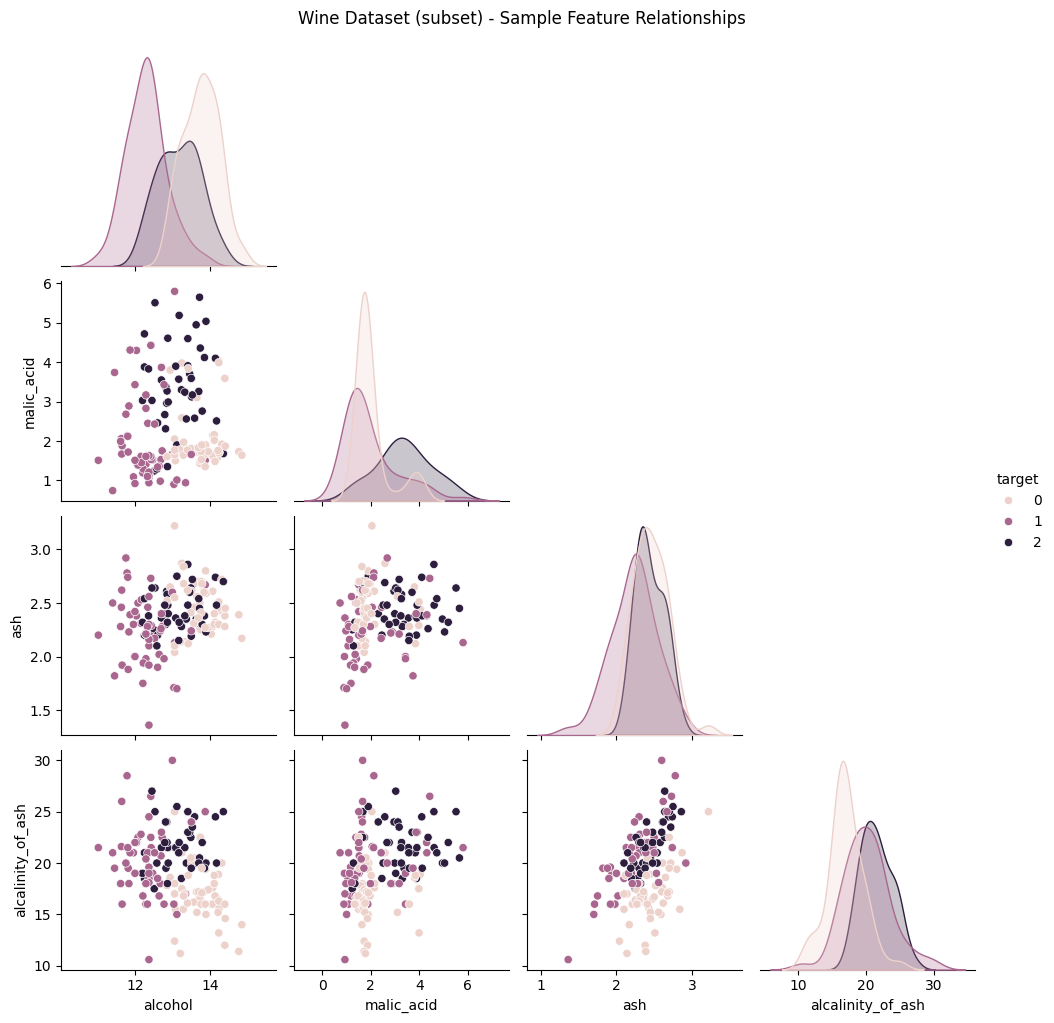

In [8]:
# Load dataset (Wine), standardize features, and preview
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# Load Wine dataset (13 features, good for dimensionality reduction)
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
class_names = wine.target_names

print("Dataset: Wine")
print(f"Shape: X={X.shape}, y={y.shape}")
print(f"Classes: {list(class_names)}")

# Create DataFrame for EDA
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Standardize features (critical for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeature means after scaling (approx 0):", np.round(X_scaled.mean(axis=0), 3))
print("Feature stds after scaling (approx 1):", np.round(X_scaled.std(axis=0), 3))

# Pairplot sample for a quick look (subset to avoid clutter)
sns.pairplot(df.sample(n=min(150, len(df))), vars=feature_names[:4], hue='target', diag_kind='kde', corner=True)
plt.suptitle('Wine Dataset (subset) - Sample Feature Relationships', y=1.02)
plt.show()

### Interpreting the Data Load, Scaling, and Pairplot Outputs

- Dataset summary:
  - The printed shape confirms 178 samples with 13 features and a 3‑class target.
  - Class names show the three wine cultivars present in the dataset.

- Standardization check:
  - Means ~ 0 and std ~ 1 indicate features were standardized correctly (critical for PCA so no single feature dominates variance by scale).

- Pairplot (first 4 features):
  - Diagonal density plots show per‑class distributions per feature.
  - Off‑diagonal scatter plots show relationships between feature pairs; clusters/higher separability suggest features useful for discrimination.
  - Overlap indicates where raw features alone may not cleanly separate classes—motivation for PCA to find better directions of variance.

Explained variance ratio (2 PCs): [0.362  0.1921]
Cumulative explained variance (2 PCs): 0.5541


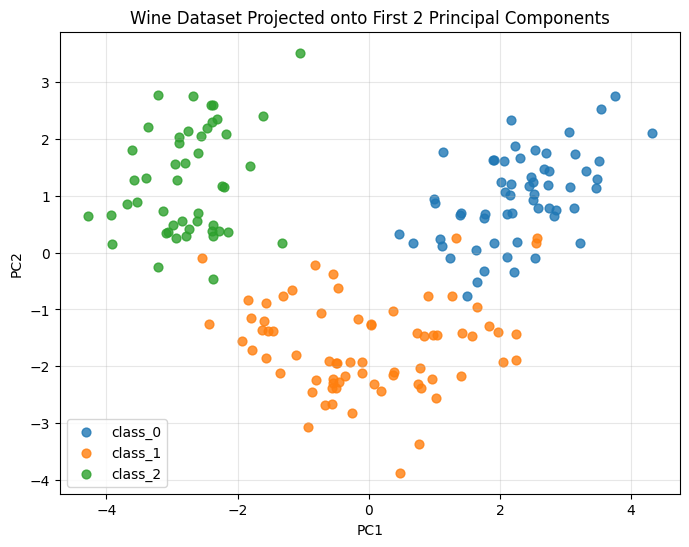

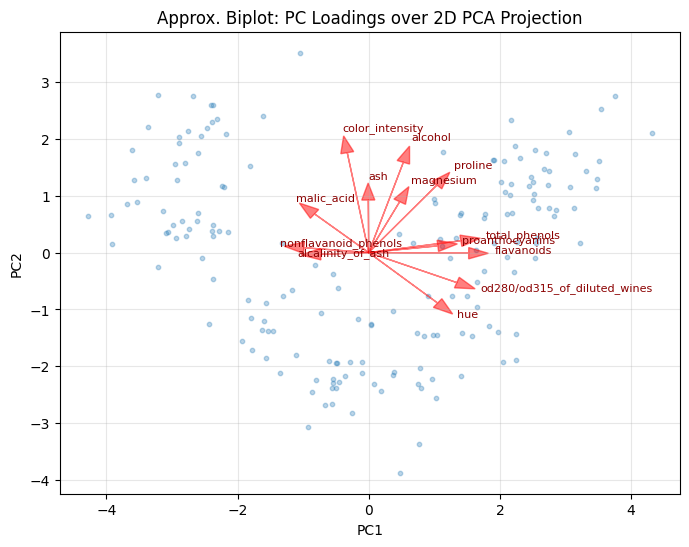

In [9]:
# Illustration - Finding Principal Components with scikit-learn PCA
from sklearn.decomposition import PCA

# Keep 2 components for visualization
pca_2 = PCA(n_components=2, svd_solver='auto', random_state=42)
X_pca_2 = pca_2.fit_transform(X_scaled)

print("Explained variance ratio (2 PCs):", np.round(pca_2.explained_variance_ratio_, 4))
print("Cumulative explained variance (2 PCs):", np.round(pca_2.explained_variance_ratio_.sum(), 4))

# 2D scatter by class
plt.figure(figsize=(8, 6))
for c, name in enumerate(class_names):
    plt.scatter(X_pca_2[y == c, 0], X_pca_2[y == c, 1], s=40, alpha=0.8, label=name)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Wine Dataset Projected onto First 2 Principal Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Biplot-style feature vectors (loadings) for interpretation
loadings = pca_2.components_.T  # shape: (n_features, 2)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], s=10, alpha=0.3, label='Samples')

# Draw arrows for top contributing features
scales = np.max(np.abs(X_pca_2), axis=0)
for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, loadings[i, 0]*scales[0], loadings[i, 1]*scales[1], 
              color='red', alpha=0.5, head_width=0.2, length_includes_head=True)
    plt.text(loadings[i, 0]*scales[0]*1.05, loadings[i, 1]*scales[1]*1.05, feature, color='darkred', fontsize=8)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Approx. Biplot: PC Loadings over 2D PCA Projection')
plt.grid(True, alpha=0.3)
plt.show()

### Understanding the PCA (2D) Outputs

- Explained variance ratio:
  - The two numbers printed are the fraction of total variance captured by PC1 and PC2.
  - Their sum (cumulative explained variance) indicates how much information is preserved in 2D.

- 2D scatter (PC1 vs PC2):
  - Points are colored by class. Better separation implies PCA found directions aligning with class differences (unsupervised but helpful for visualization).
  - PC axes are orthogonal and uncorrelated by construction.

- Biplot-style loadings:
  - Red arrows show how original features contribute to PCs; longer arrows indicate stronger influence.
  - Direction of an arrow suggests correlation with that PC; features pointing in similar directions are positively correlated.
  - Use this to interpret which chemical attributes drive separation along PC1/PC2.

Explained variance ratio (cov eigen): [0.362  0.1921]
Cumulative explained variance (cov eigen, 2 PCs): 0.5541


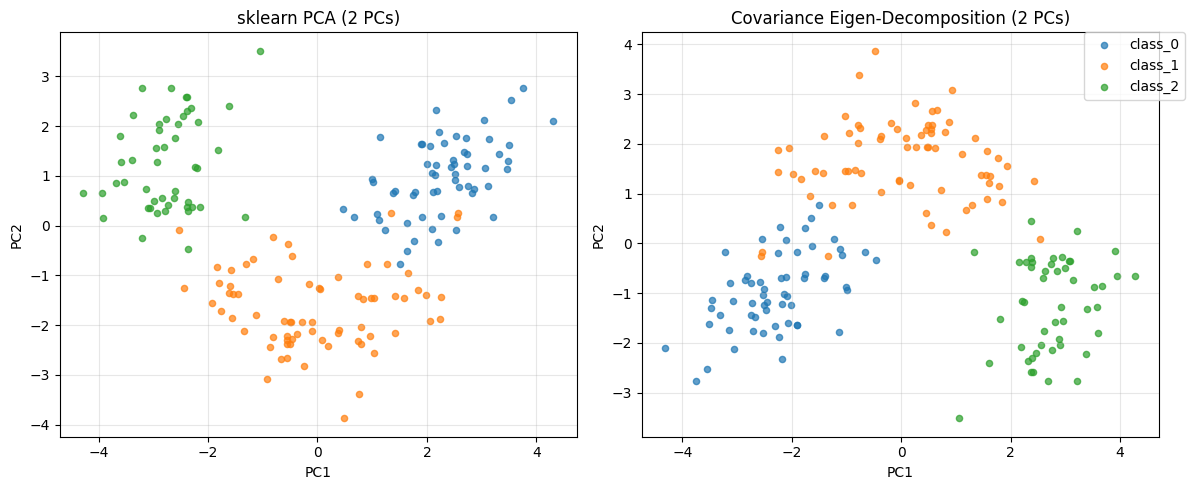

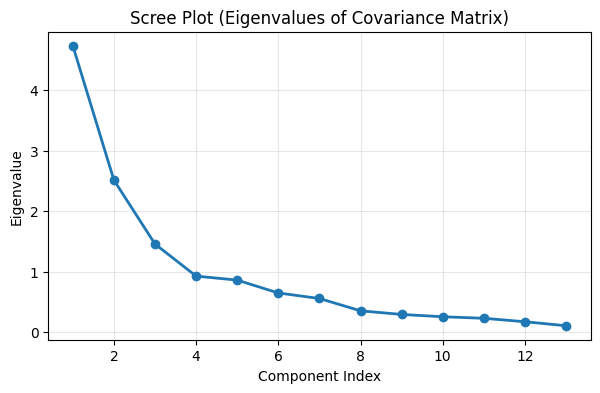

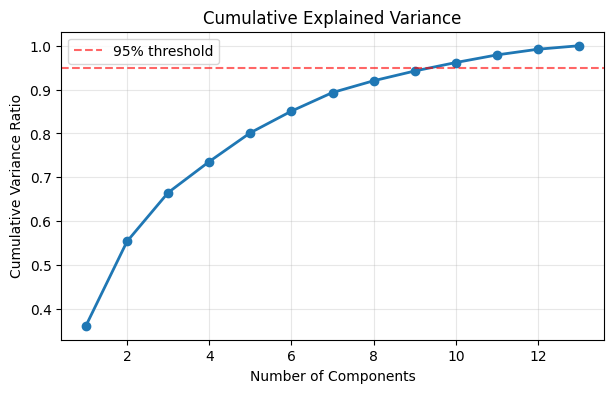

In [10]:
# Comprehension - Calculating Principal Components (Covariance & SVD)

# 1) Center the scaled data (StandardScaler already centers/standardizes)
Xc = X_scaled - X_scaled.mean(axis=0)

# 2) Covariance matrix
cov = np.cov(Xc, rowvar=False)

# 3) Eigen-decomposition of covariance
eigvals, eigvecs = np.linalg.eigh(cov)  # eigh for symmetric matrices
# Sort by descending eigenvalues
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# 4) Project data onto first 2 eigenvectors
X_pca_cov_2 = Xc @ eigvecs[:, :2]

# Compare explained variance with scikit-learn PCA
explained_cov = eigvals / eigvals.sum()
print("Explained variance ratio (cov eigen):", np.round(explained_cov[:2], 4))
print("Cumulative explained variance (cov eigen, 2 PCs):", np.round(explained_cov[:2].sum(), 4))

# 5) SVD-based PCA (conceptual alignment)
U, S, VT = np.linalg.svd(Xc, full_matrices=False)
# Scores (projected data) ~ U * S; Loadings (components) ~ VT^T
X_pca_svd_2 = U[:, :2] * S[:2]
components_svd_2 = VT[:2, :].T  # shape (n_features, 2)

# Visual check: compare scikit-learn PCA projection vs covariance eigen projection
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for c, name in enumerate(class_names):
    plt.scatter(X_pca_2[y == c, 0], X_pca_2[y == c, 1], s=20, alpha=0.7, label=name)
plt.title('sklearn PCA (2 PCs)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for c, name in enumerate(class_names):
    plt.scatter(X_pca_cov_2[y == c, 0], X_pca_cov_2[y == c, 1], s=20, alpha=0.7, label=name)
plt.title('Covariance Eigen-Decomposition (2 PCs)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.grid(True, alpha=0.3)
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

# Scree plot (eigenvalues)
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(eigvals)+1), eigvals, 'o-', lw=2)
plt.title('Scree Plot (Eigenvalues of Covariance Matrix)')
plt.xlabel('Component Index'); plt.ylabel('Eigenvalue'); plt.grid(True, alpha=0.3)
plt.show()

# Cumulative explained variance plot
cum_explained = np.cumsum(explained_cov)
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, 'o-', lw=2)
plt.axhline(y=0.95, color='red', linestyle='--', alpha=0.6, label='95% threshold')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components'); plt.ylabel('Cumulative Variance Ratio')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

### Decoding the Eigen / SVD PCA and Diagnostics

- Covariance eigen-decomposition:
  - Eigenvalues represent variance captured by each component; eigenvectors are the component directions.
  - The printed explained variance ratios (first two) should closely match sklearn’s output.
  - The side-by-side plots compare sklearn’s SVD-based PCA projection and the covariance-eigen projection—visual agreement validates correctness.

- SVD perspective:
  - U, S, Vᵀ from SVD yield scores (U·S) and loadings (V), aligning with PCA’s components and projections.

- Scree plot:
  - Shows eigenvalues by component index; look for an “elbow” where marginal gains drop, guiding how many components to keep.

- Cumulative explained variance:
  - The curve helps select k to reach a target (e.g., 95%).
  - Crossing the 0.95 line indicates the minimum number of PCs needed to retain ~95% of variance.

## Visualization: Before vs After PCA

To understand PCA’s effect, we compare the original feature space (two raw features) against the 2D PCA projection (PC1 vs PC2). The PCA view maximizes class-separating variance and removes correlation by construction.

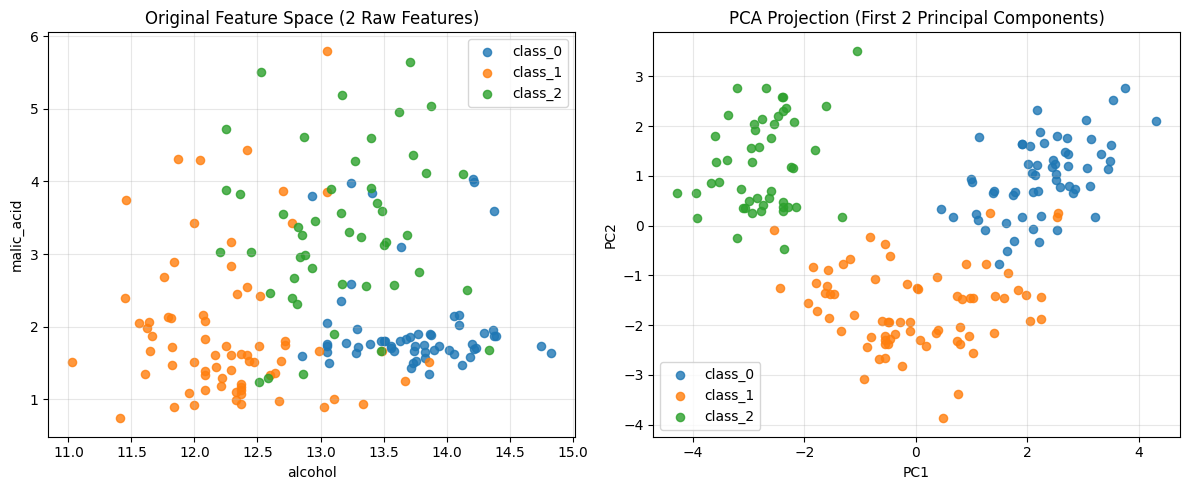

In [11]:
# Before vs After PCA Visualization
plt.figure(figsize=(12, 5))

# Pick two raw features that show some correlation
f1, f2 = 0, 1  # Alcohol vs Malic acid in Wine dataset

plt.subplot(1, 2, 1)
for c, name in enumerate(class_names):
    plt.scatter(X[:, f1][y == c], X[:, f2][y == c], s=35, alpha=0.8, label=name)
plt.xlabel(feature_names[f1])
plt.ylabel(feature_names[f2])
plt.title('Original Feature Space (2 Raw Features)')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for c, name in enumerate(class_names):
    plt.scatter(X_pca_2[y == c, 0], X_pca_2[y == c, 1], s=35, alpha=0.8, label=name)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection (First 2 Principal Components)')
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpreting Before vs After PCA

- Original feature plane (two raw features):
  - May show overlapping classes and correlated axes; separation depends on selected features.

- PCA 2D projection:
  - Optimizes axes to capture maximal variance; often reveals clearer structure.
  - Axes are uncorrelated; relative class compactness and separation are easier to judge.

- Takeaways:
  - PCA improves visualization and may benefit downstream models by reducing noise/correlation.
  - Always standardize first and validate how many PCs are needed via explained variance.